In [1]:
%matplotlib inline
import bs4
import numpy as np
import pandas as pd
import geopandas as gp
import re
import urllib3
import matplotlib
import json
import matplotlib.pyplot as plt
import datetime as dt
matplotlib.style.use('ggplot')

In [2]:
def camel_to_snake(column_name):
    """
    converts a string that is camelCase into snake_case
    Example:
        print camel_to_snake("javaLovesCamelCase")
        > java_loves_camel_case
    See Also:
        http://stackoverflow.com/questions/1175208/elegant-python-function-to-convert-camelcase-to-camel-case
    """
    
    if ' ' in column_name:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)
        return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower().replace(' ','_')
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [3]:
cap = pd.read_csv('2017-Q1-Trips-History-Data.csv')

In [6]:
cap_loc = pd.read_csv('Capital_Bike_Share_Locations.csv')

In [128]:
def lower_cols(df):
    name_dict= {n:camel_to_snake(n) for n in df.columns}
    return df.rename(columns=name_dict)

cap = lower_cols(cap)

cap_loc = lower_cols(cap_loc)

In [8]:
cap['end_datetime'] = pd.to_datetime(cap.end_date)
cap['start_datetime'] = pd.to_datetime(cap.start_date)

In [9]:
cap_merge = pd.merge(cap,cap_loc, how = 'left', left_on = 'start_station_number' , right_on ='terminal_number')

In [10]:
cap_loc.head()

,objectid,id,address,terminal_number,latitude,longitude,installed,locked,install_date,removal_date,temporary_install,number_of_bikes,number_of_empty_docks,x,y,se_anno_cad_data
0,159554260,1,Eads St & 15th St S,31000,38.858971,-77.053230,YES,NO,NaN,NaN,NO,5,8,395379.968612,132352.116903,NaN
1,159554261,2,18th & Eads St.,31001,38.857250,-77.053320,YES,NO,NaN,NaN,NO,3,8,395372.045590,132161.078081,NaN
2,159554262,3,20th & Crystal Dr,31002,38.856425,-77.049232,YES,NO,NaN,NaN,NO,8,8,395726.817575,132069.297863,NaN
3,159554263,4,15th & Crystal Dr,31003,38.860170,-77.049593,YES,NO,NaN,NaN,NO,6,4,395695.709759,132485.036787,NaN
4,159554264,5,Aurora Hills Community Ctr/18th & Hayes St,31004,38.857866,-77.059490,YES,NO,NaN,NaN,NO,8,3,394836.559865,132229.789390,NaN


In [11]:
to_from = cap_merge.groupby(['start_station','end_station']).size().to_frame().reset_index().rename(columns={0:'freq'})

In [12]:
to_from.freq.median()

5.0

In [13]:
to_from_mt_pleasant = to_from[to_from.start_station == 'Lamont & Mt Pleasant NW'][to_from.freq > int(to_from.mean())]

/Users/andrewyaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [14]:
lamont_end_locs = pd.merge(to_from_mt_pleasant,cap_loc, how='left', left_on ='end_station', right_on ='address')
lamont_end_locs = lamont_end_locs[['start_station','end_station','freq','latitude','longitude']]

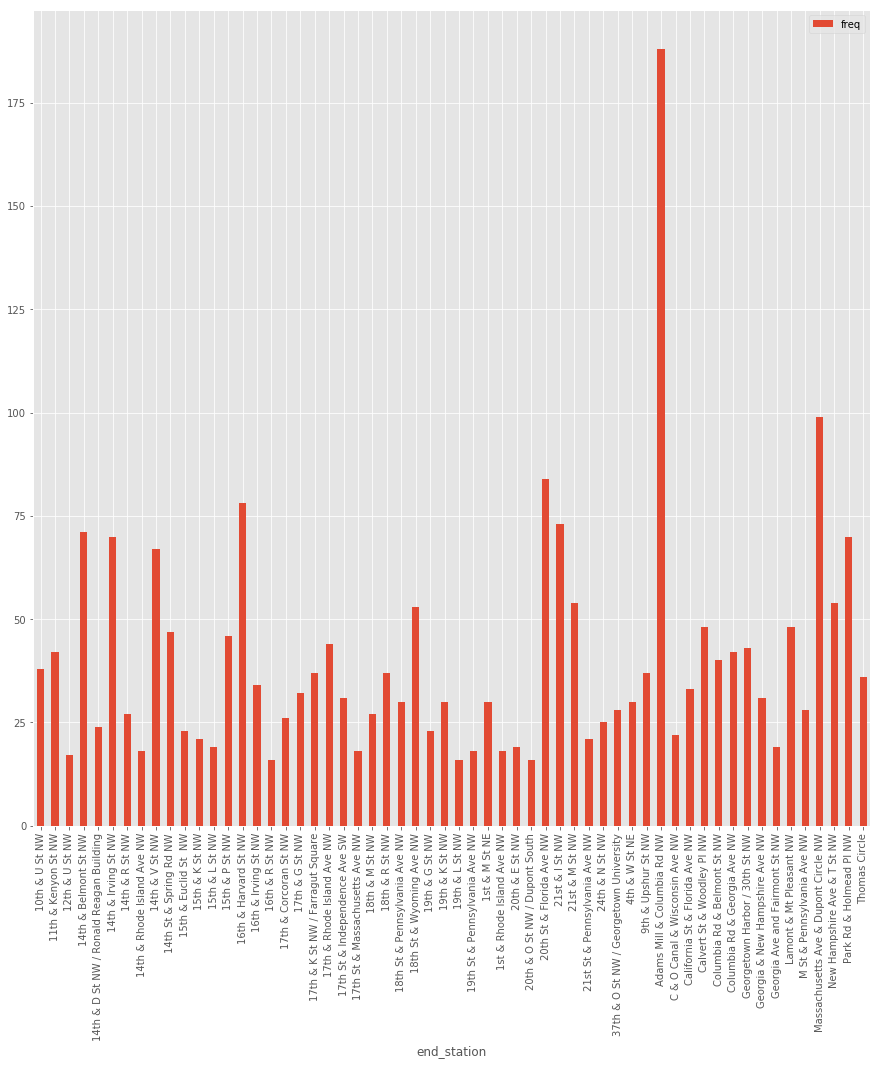

In [51]:
to_from_mt_pleasant.plot(kind='bar',x='end_station',y='freq',figsize=(15,15))

In [162]:
dc = gp.read_file('Neighborhood_Clusters.geojson')
dc = lower_cols(dc)
dc.columns
dc.nbh_names
dc.iloc[33].to_frame().transpose()

,name,nbh_names,objectid,shape__area,shape__length,type,web_url,geometry
33,Cluster 2,"Columbia Heights, Mt. Pleasant, Pleasant Plain...",34,3.40011e+06,9153.21,Original,http://planning.dc.gov/,POLYGON ((-77.03523283853575 38.93743450516157...


"\nbase = dc[dc.index==5].plot(column='Shape_Area', cmap='Blues', figsize=(15,15))\nbound_table = dc[dc.index==5].bounds.reset_index().iloc[0]\n#lamont_end_locs.plot(ax=base,kind='scatter', x='longitude', y='latitude', figsize=(15,15), color='blue')\ncap_loc.plot(ax=base, kind='scatter', x='longitude', y='latitude', figsize=(15,15), color='red', s = 30 )\n#ax1 = plt.subplot(111)\n\nfor station in cap_loc.iterrows():\n    base.annotate(station[1].address, (station[1].longitude, station[1].latitude))\n\nbase.set_xlim([bound_table['minx'], bound_table['maxx']])\nbase.set_ylim([bound_table['miny'], bound_table['maxy']])\n"

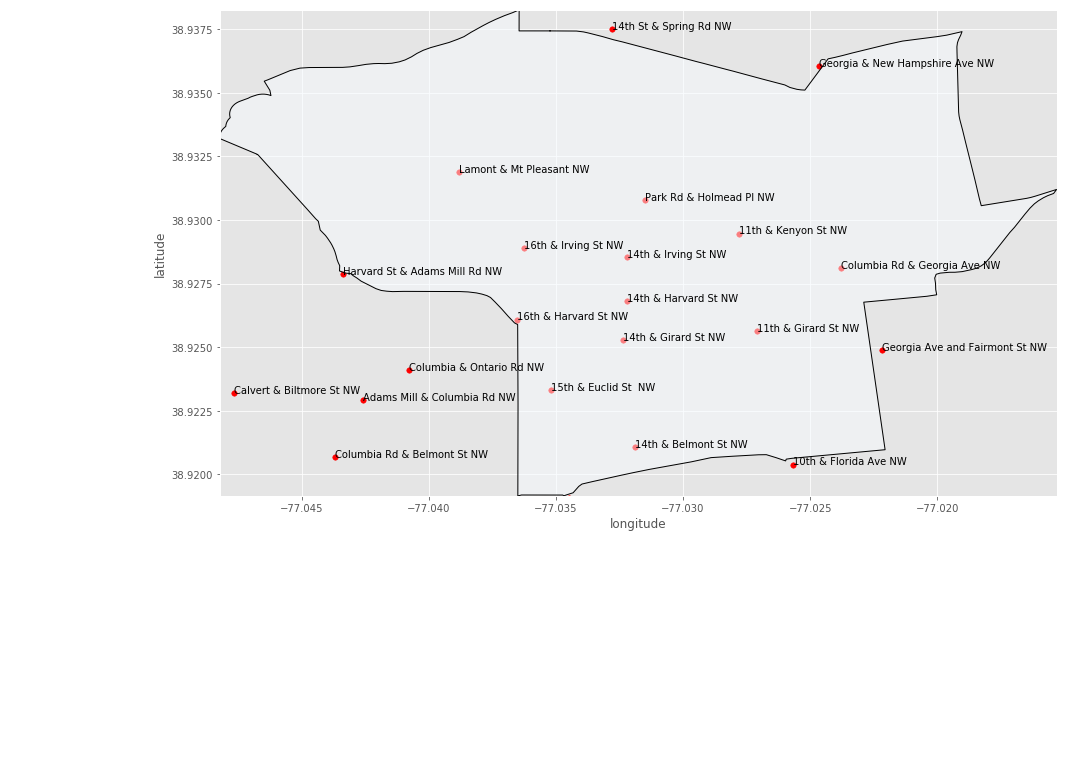

In [183]:

def plot_nb(df,locations_df, nb_col, shape_col, nb_num, lat_col, long_col):
    '''
    neighborhood = column or list of columns
    '''
    df = lower_cols(df)
    neighborhood_rows = gp.GeoDataFrame(df.iloc[33].to_frame().transpose())
    #print(neighborhood_rows.geometry)
    base = neighborhood_rows.plot(column = shape_col, cmap='Blues', figsize=(15,15))
    bound_table = neighborhood_rows.loc[nb_num].geometry.bounds
    #lamont_end_locs.plot(ax=base,kind='scatter', x='longitude', y='latitude', figsize=(15,15), color='blue')
    cap_loc.plot(ax=base, kind='scatter', x=long_col, y=lat_col, figsize=(15,15), color='red', s = 30 )
    #ax1 = plt.subplot(111)

    for station in locations_df.iterrows():
        base.annotate(station[1].address, (station[1][long_col], station[1][lat_col]))
    
    #print(bound_table)
    base.set_xlim([bound_table[0], bound_table[2]])
    base.set_ylim([bound_table[1], bound_table[3]])

plot_nb(dc, cap_loc, 'nbh_names', 'shape__area',33,'latitude','longitude')


'''
inspiration
base = dc[dc.index==5].plot(column='Shape_Area', cmap='Blues', figsize=(15,15))
bound_table = dc[dc.index==5].bounds.reset_index().iloc[0]
#lamont_end_locs.plot(ax=base,kind='scatter', x='longitude', y='latitude', figsize=(15,15), color='blue')
cap_loc.plot(ax=base, kind='scatter', x='longitude', y='latitude', figsize=(15,15), color='red', s = 30 )
#ax1 = plt.subplot(111)

for station in cap_loc.iterrows():
    base.annotate(station[1].address, (station[1].longitude, station[1].latitude))

base.set_xlim([bound_table['minx'], bound_table['maxx']])
base.set_ylim([bound_table['miny'], bound_table['maxy']])
'''

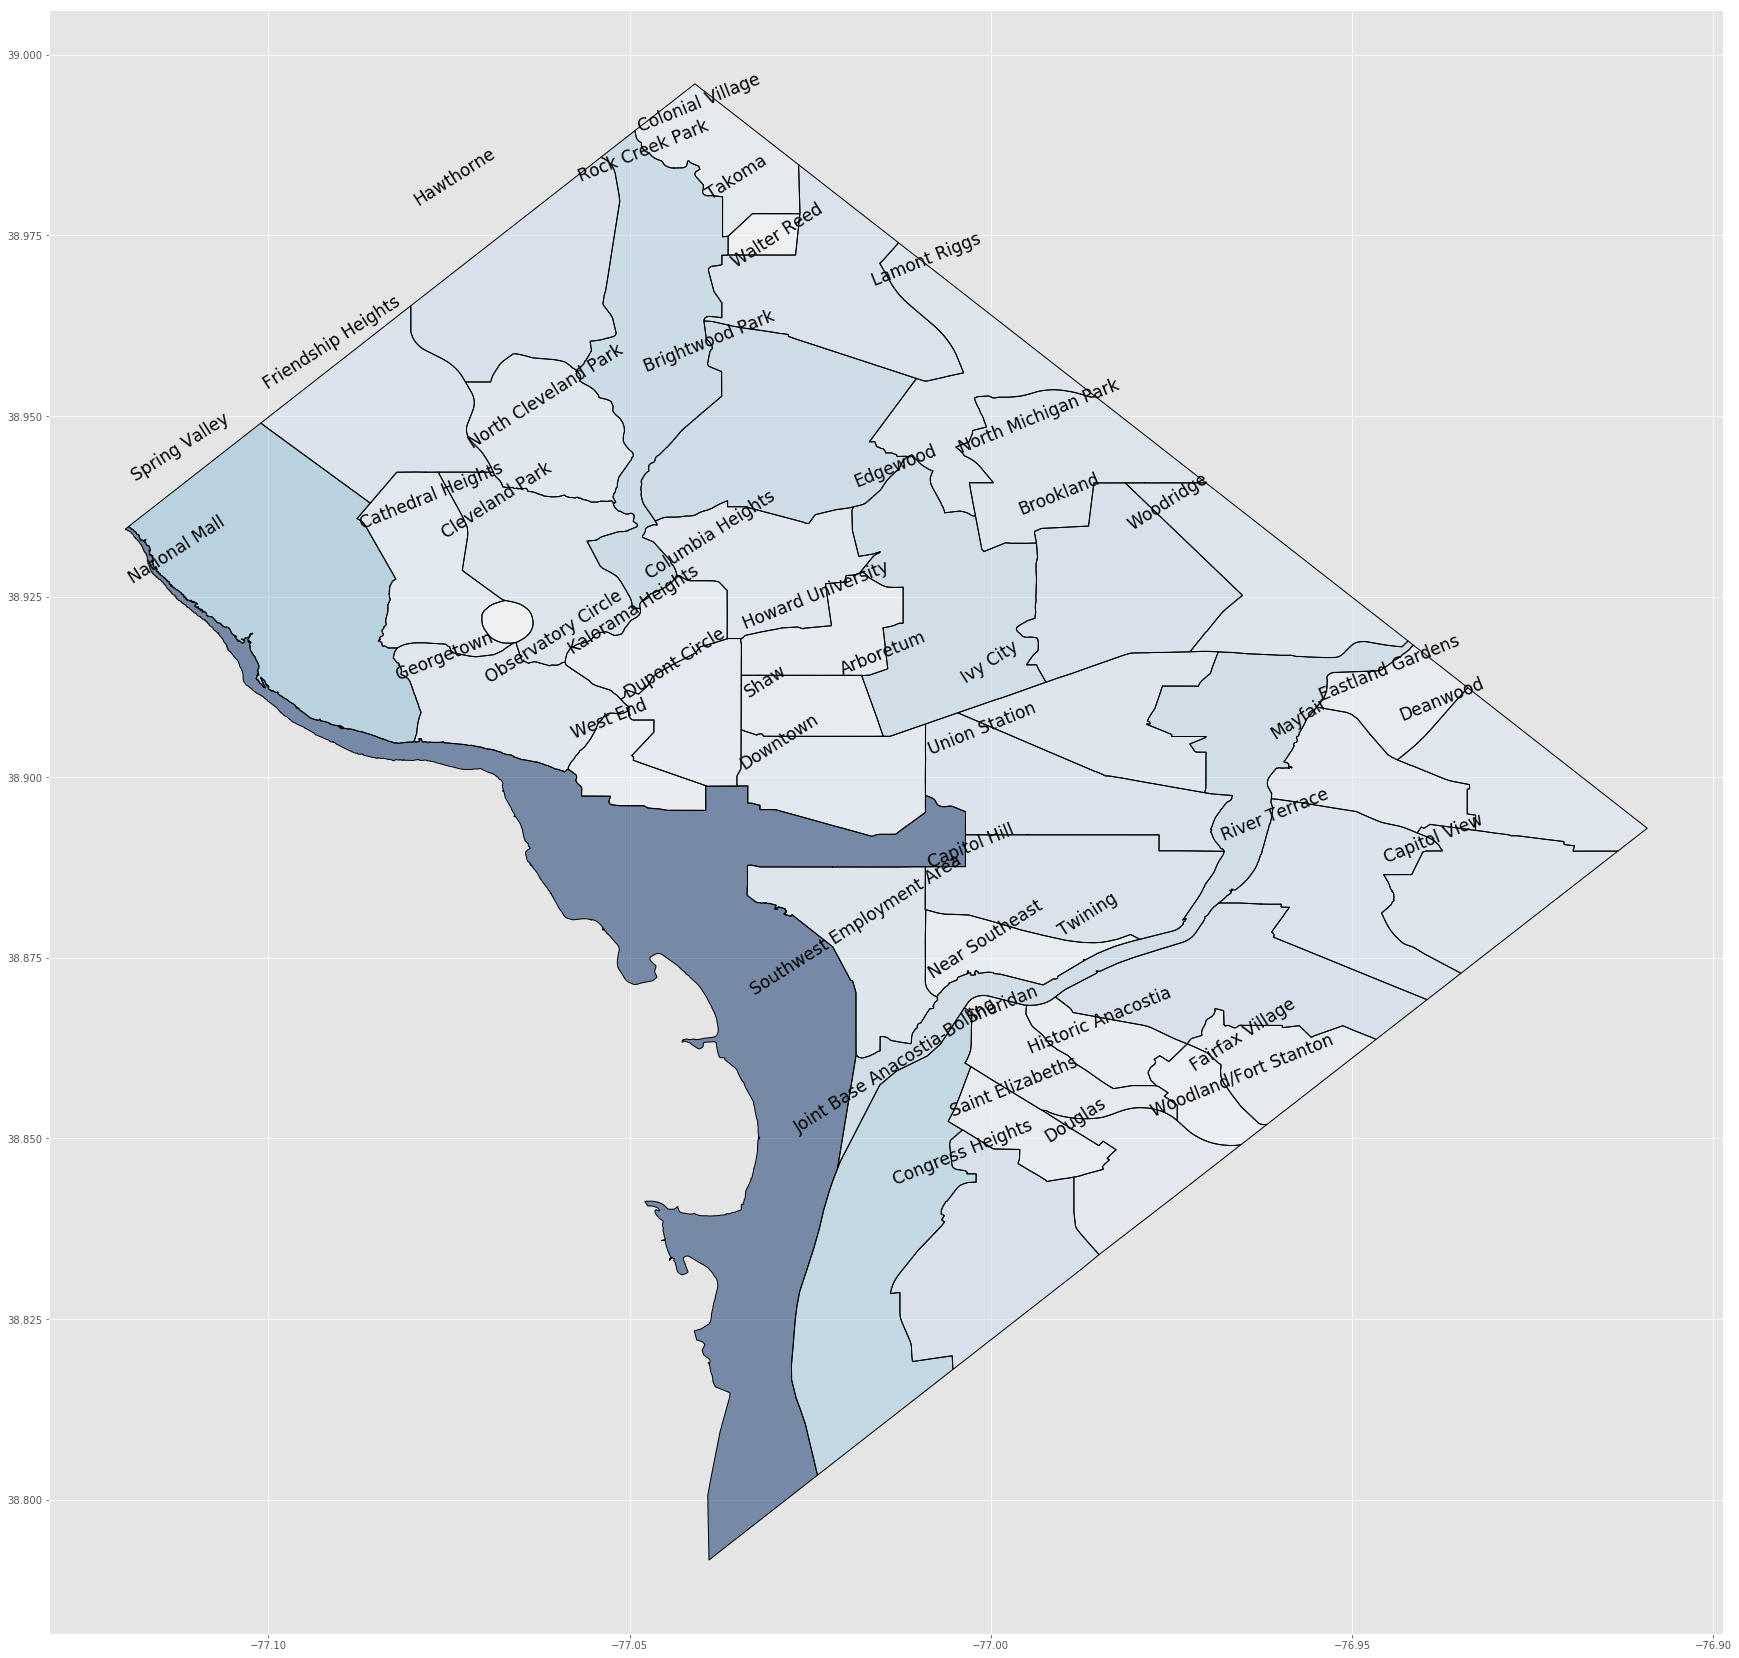

In [296]:
base = dc.plot(column='Shape_Area', cmap='Blues', figsize=(30,30))
for idx,station in enumerate(dc.iterrows()):
    if idx%2:
        r = 32.5
    else:
        r = 22
    plt.annotate(station[1].NBH_NAMES.split(',')[0], xy=(station[1].geometry.bounds[0],station[1].geometry.bounds[3]),horizontalalignment='left',rotation=r, size=17)
    

In [234]:
dc.head()

,NAME,NBH_NAMES,OBJECTID,Shape_Area,Shape_Length,TYPE,WEB_URL,geometry
0,Cluster 39,"Congress Heights, Bellevue, Washington Highlands",1,4.886463e+06,10711.668010,Original,http://planning.dc.gov/,POLYGON ((-76.99401890037231 38.84519662346873...
1,Cluster 38,"Douglas, Shipley Terrace",2,2.367958e+06,8229.486324,Original,http://planning.dc.gov/,"POLYGON ((-76.97471813575507 38.8528706360112,..."
2,Cluster 36,"Woodland/Fort Stanton, Garfield Heights, Knox ...",3,1.119573e+06,4746.344457,Original,http://planning.dc.gov/,"POLYGON ((-76.9687730019474 38.86067206227963,..."
3,Cluster 27,"Near Southeast, Navy Yard",4,1.619167e+06,7286.968902,Original,http://planning.dc.gov/,"POLYGON ((-76.9872595922274 38.87711832849107,..."
4,Cluster 32,"River Terrace, Benning, Greenway, Dupont Park",5,4.286254e+06,11251.012821,Original,http://planning.dc.gov/,POLYGON ((-76.93760147029893 38.88995958845385...


In [257]:
dc.iloc[1].geometry.bounds[0]

-76.99291178416006

In [17]:
l = []
for x in cap.iterrows():
    if x[1][-2].date().isoweekday() == 1:
        l.append(True)
        #print(True)
    else:
        l.append(False)
        #print(False)
        
c = pd.DataFrame(l)

In [18]:
l = []
for x in cap.iterrows():
    if x[1][-2].time().hour == 9:
        l.append(True)
        #print(True)
    else:
        l.append(False)
        #print(False)
        
h = pd.DataFrame(l)


In [19]:
is_11F = cap.end_station == '11th & F St NW'
is_10G = cap.end_station == '10th & G St NW'
is_Metro = cap.end_station == 'Metro Center / 12th & G St NW'
metro_center_freq = cap[c[0]][is_11F| is_10G| is_Metro][h[0]].end_station.value_counts()

/Users/andrewyaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [34]:
mf = metro_center_freq.to_frame().rename(columns={'end_station':'freq'})

,freq
Metro Center / 12th & G St NW,68
10th & G St NW,64
11th & F St NW,28


In [38]:
mf

,freq,norm
Metro Center / 12th & G St NW,68,NaN
10th & G St NW,64,NaN
11th & F St NW,28,NaN


In [55]:
cap_loc[cap_loc.address==r[0]].number_of_bikes

118    1
Name: number_of_bikes, dtype: int64

In [95]:
t = mf.freq.apply(lambda x: x)

In [96]:
t

Metro Center / 12th & G St NW    68
10th & G St NW                   64
11th & F St NW                   28
Name: freq, dtype: int64

In [111]:
mf['norm'] = mf.l_index.apply(lambda r: mf.loc[r].freq/int(cap_loc[cap_loc.address==r].number_of_bikes + cap_loc[cap_loc.address==r].number_of_empty_docks))

In [108]:
mf['l_index'] = mf.index

In [112]:
mf

,freq,norm,l_index
Metro Center / 12th & G St NW,68,2.266667,Metro Center / 12th & G St NW
10th & G St NW,64,2.782609,10th & G St NW
11th & F St NW,28,1.866667,11th & F St NW


(0, 3)

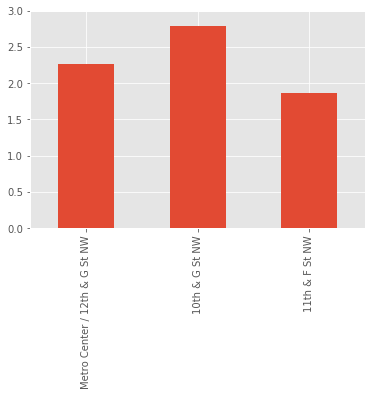

In [124]:
mf.norm.plot(kind='bar')
plt.ylim(0,3)